### Load the model

In [7]:
import LLM_builder

llm = LLM_builder.loadGoogleGenerativeAI()
print(llm.invoke("Hello, how are you?"))

content='I am doing well, thank you for asking! How are you today?' additional_kwargs={} response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'model_name': 'gemini-2.0-flash', 'safety_ratings': []} id='run--3573072d-cec3-4b25-827e-9974810ae65c-0' usage_metadata={'input_tokens': 6, 'output_tokens': 16, 'total_tokens': 22, 'input_token_details': {'cache_read': 0}}


### Define Agent State

We'll define the state that our agent will maintain throughout its operation. First, define the [State](https://langchain-ai.github.io/langgraph/concepts/low_level/#state) of the graph.  The State schema serves as the input schema for all Nodes and Edges in the graph.

itinerary -> a plan of a journey, including the route and the places that you will visit

In [8]:
from typing import Annotated, List, TypedDict
from langchain.schema import HumanMessage, AIMessage

class PlannerState(TypedDict):
    """The state of the planner agent"""
    messages: Annotated[List[HumanMessage | AIMessage], "The messages in the conversation"]
    itinerary: str
    city: str
    user_message: str

### Set up prompt
#### 🔍 `MessagesPlaceholder` — What It Is

`MessagesPlaceholder` is a utility class in LangChain that allows you to insert a dynamic list of chat messages (like previous conversation history) into a `ChatPromptTemplate`.

#### 🧠 Purpose

In a chat-based agent or app, you often need to provide the full chat history to the LLM so it can respond contextually. However, you don't want to hardcode the entire history in your prompt. Instead, you want to "inject" it dynamically when invoking the prompt.

#### 🔁 How MessagesPlaceholder Works Under the Hood
- It does not have static content.
- It acts as a token in the message template, which gets replaced at runtime.
- You must provide the actual content during format() or .invoke() call.

#### ✅ Correct Usage:
```python
    prompt = ChatPromptTemplate.from_messages([
        ("system", "You are a helpful assistant."),
        MessagesPlaceholder("chat_history"),
        ("human", "{question}")
    ])

    chat_history = [
        HumanMessage(content="What’s the weather like in Paris?"),
        AIMessage(content="It's sunny in Paris."),
    ]

    final_prompt = prompt.format(
        chat_history=chat_history,
        question="What about tomorrow?"
)
```

In [9]:
from langchain.prompts.chat import ChatPromptTemplate, MessagesPlaceholder

itinerary_prompt = ChatPromptTemplate.from_messages([
    ("system", """You are a helpful travel assistant. Create a day trip itinerary for {city} based on the user's interests. 
    Follow these instructions:
    1. Use the below chat conversation and the latest input from Human to get the user interests.
    2. Always account for travel time and meal times - if its not possible to do everything, then say so.
    3. If the user hasn't stated a time of year or season, assume summer season in {city} and state this assumption in your response.
    4. If the user hasn't stated a travel budget, assume a reasonable dollar amount and state this assumption in your response.
    5. Provide a brief, bulleted itinerary in chronological order with specific hours of day."""),
    MessagesPlaceholder("chat_history"),
    ("human", "{user_message}"),
])

### Create node function
- ```state.get('messages', None)``` -> `if 'messages' in state: value = state['messages'] else: value = None`

In [ ]:
def create_itinerary(state: PlannerState) -> PlannerState:

    if not state.get('messages', None) : state['messages'] = []

    response = llm.invoke(itinerary_prompt.format_messages(city=state['city'], user_mesage=state['user_message'], chat_history=state['messages']))
    print("\nFinal Itinerary: ", response.content)

    # Keeps all the previous states and update messages and itinerary
    return {
        **state,
        "messages": state['messages'] + [HumanMessage(content=state['user_message']), AIMessage(content=response.content)],
        "itinerary": response.content
    }

#### 🧠 What is `MemorySaver` in LangGraph?
`MemorySaver` is a checkpointing mechanism that helps store the state of your graph during execution. This means it remembers the state (a dictionary of values) between steps in your LangGraph-based workflow.

#### 🔍 Why Do You Need This?
LangGraph is a stateful graph execution engine. It processes inputs (like user requests) step-by-step through nodes (functions), updating and passing state between them.

But what happens if:

- The workflow gets interrupted?
- You want to resume from where it left off?
- You want to debug or inspect what happened at each step?
- That's where checkpointing comes in.

#### 📦 MemorySaver — How It Works
MemorySaver is one of the simplest built-in checkpointers. It
- Stores the entire state (i.e., PlannerState) in memory (RAM).
- Keeps track of all intermediate steps of the graph execution.
- Useful for debugging, local development, and experimentation.
- It does not persist data to disk or database — it’s purely in-memory, so if you stop the program, everything is lost.

#### 🧪 Example Behavior
Let’s say your PlannerState looks like:
```python
{
    "user_message": "Plan a trip with boating and swimming",
    "city": "Seattle"
}
```
As the state flows through the graph:

`input_interests` runs and maybe appends to `state["messages"]`.
`create_itinerary` runs and adds `state["itinerary"]`.
At each step, MemorySaver stores the state like:
```python
Step 1: {'user_message': ..., 'city': ...}
Step 2: {'user_message': ..., 'city': ..., 'messages': [...]}
Step 3: {'user_message': ..., 'city': ..., 'messages': [...], 'itinerary': "..."}
```
You can even inspect all checkpoints after execution using:

`memory.data`

In [ ]:
from langgraph.graph import StateGraph, START, END
from langgraph.checkpoint.memory import MemorySaver

workflow = StateGraph(PlannerState)

#workflow.add_node("input_city", input_city)
# workflow.add_node("input_interests", input_interests)
workflow.add_node("create_itinerary", create_itinerary)

# workflow.set_entry_point("input_interests")

#workflow.add_edge("input_city", "input_interests")
workflow.add_edge(START, "create_itinerary")
workflow.add_edge("create_itinerary", END)

# The checkpointer lets the graph persist its state
# this is a complete memory for the entire graph.
memory = MemorySaver()
app = workflow.compile(checkpointer=memory)

### Display the graph structure

Finally, we [compile our graph](https://langchain-ai.github.io/langgraph/concepts/low_level/#compiling-your-graph) to perform a few basic checks on the graph structure. We can visualize the graph as a [Mermaid diagram](https://github.com/mermaid-js/mermaid).

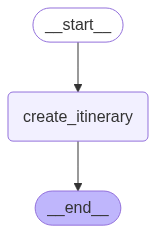

In [32]:
from IPython.display import Image, display
display(Image(app.get_graph().draw_mermaid_png()))

### Define the function that runs the graph

When we compile the graph, we turn it into a LangChain Runnable, which automatically enables calling `.invoke()`, `.stream()` and `.batch()` with your inputs. In the following example, we run `stream()` to invoke the graph with inputs

`.stream(...)` means you're running the LangGraph in streaming mode, where you get intermediate outputs one by one.

In [33]:
def run_travel_planner(user_request, config_dict: dict):
    """
    Runs the travel planner agent.
    
    :param user_request: The user's request.
    :param config_dict: The configuration dictionary.
    """
    if user_request is None:
        raise ValueError("user_request cannot be None")

    if config_dict is None:
        raise ValueError("config_dict cannot be None")

    print(f"Current User Request: {user_request}\n")
    init_input = {"user_message": user_request,"city" : "Seattle"}

    for output in app.stream(init_input, config=config_dict, stream_mode="values"):
        # print(f"Output: {output}")
        pass

In [34]:
config = {"configurable": {"thread_id": "1"}}

user_request = "Can you create a itinerary for a day trip in Seattle with boating and swimming options. Need a complete plan"
run_travel_planner(user_request, config)

Current User Request: Can you create a itinerary for a day trip in Seattle with boating and swimming options. Need a complete plan


Final Itinerary:  Okay! I can help you create a day trip itinerary for Seattle with boating and swimming options.

Since you haven't specified the time of year, I'll assume you're planning this trip for the **summer season** in Seattle to take advantage of the warmer weather. I'll also assume a reasonable budget of **$200 per person** for activities, food, and transportation.

Here's a possible itinerary:

*   **9:00 AM:** Start your day with breakfast at **Caffe Ladro** in downtown Seattle. Grab a coffee and pastry to fuel up for the day.
*   **10:00 AM:** Head to **Lake Union** for a morning of boating. Rent a boat from the **Northwest Outdoor Center** or **Seattle Boat Company**. You can choose from kayaks, paddleboards, or motorboats, depending on your preference and budget. Enjoy the views of the Seattle skyline and Gas Works Park from the water.
*  